In [3]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 982.9/982.9 kB 6.4 MB/s eta 0:00:00


In [4]:
import yfinance as yf
from arch import arch_model
from arch.__future__ import reindexing
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preparing the Data

In [6]:
# Loading the path to the folder
DATA_PATH = "/content/drive/MyDrive/studia/Inżynierka/MAIN/"

In [106]:
# Loading the prepared dataset
data = pd.read_csv(DATA_PATH + 'PreparedDataset.csv', low_memory=False)
data['Datetime'] = pd.to_datetime(data['Datetime'], utc=True)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3483 entries, 0 to 3482
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   Datetime  3483 non-null   datetime64[ns, UTC]
 1   Close     3483 non-null   float64            
 2   Returns   3483 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(2)
memory usage: 81.8 KB
None


## Preparing the data

In [107]:
prices = data[['Datetime', 'Close']]
prices = prices.set_index('Datetime')
returns = data['Returns']

## Splitting the data

In [108]:
train_size = int(len(returns) * 0.7)
train_returns = returns[:train_size]
test_returns = returns[train_size:]

## GARCH MODEL

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2016.29
Distribution:                  Normal   AIC:                           4040.58
Method:            Maximum Likelihood   BIC:                           4063.77
                                        No. Observations:                 2438
Date:                Sun, Oct 27 2024   Df Residuals:                     2437
Time:                        18:21:19   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         9.7397e-03  1.101e-02      0.885      0.376 

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


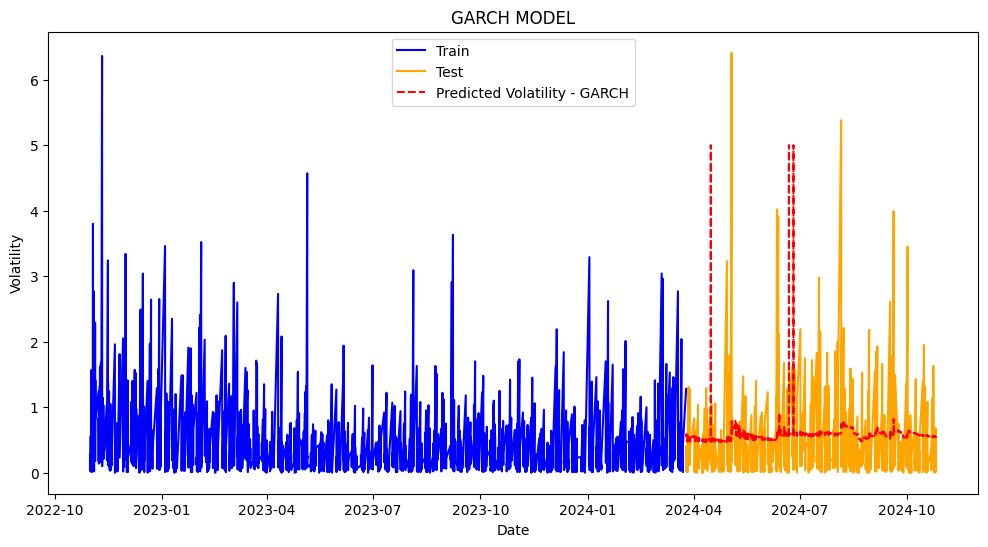

Mean Squared Error (MSE): 0.3745
Root Mean Squared Error (RMSE): 0.6119
Mean Absolute Error (MAE): 0.4259


In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Fitting GARCH MODEL order (1, 1) on the training data
model = arch_model(train_returns, vol='GARCH', p=1, q=1)

# Defining iteration limit to 10,000
options = {'maxiter': 10000}

# Fitting GARCH MODEL
model_fit = model.fit(disp='off', options=options)

# GARCH MODEL summary
print(model_fit.summary())

# Rolling forecast for test data
history = train_returns.tolist()
predicted_volatility = []

for t in range(len(test_returns)):
    # Fitting GARCH MODEL on the rolling window (using historical data)
    model = arch_model(history, vol='GARCH', p=1, q=1)

    try:
        model_fit = model.fit(disp='off', options=options)
    except Exception as e:
        print(f"Rolling forecast iteration {t} generates an error:", e)
        predicted_volatility.append(np.nan)
        history.append(test_returns.iloc[t])
        continue

    # Forecasting the volatility for the next time point
    forecast = model_fit.forecast(horizon=1)
    # Extracting the predicted volatility
    pred_vol = np.sqrt(forecast.variance.values[-1, 0])

    # Ensuring predicted volatility is non-negative and limiting overflow
    if pred_vol > 5:
        pred_vol = 5

    if pred_vol < 0:
        pred_vol = 0

    # Append the predicted volatility
    predicted_volatility.append(pred_vol)

    # Update history with the actual value from test_returns
    history.append(test_returns.iloc[t])

# Convert predicted volatilities to a Pandas Series
predicted_volatility = pd.Series(predicted_volatility, index=test_returns.index)

# Plotting the training, test, and predicted volatility
plt.figure(figsize=(12, 6))
plt.plot(prices.index[:train_size], np.abs(train_returns), label='Train', color="blue")
plt.plot(prices.index[train_size:], np.abs(test_returns), label='Test', color="orange")
plt.plot(prices.index[train_size:], predicted_volatility, label='Predicted Volatility - GARCH', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('GARCH MODEL')
plt.legend()
plt.show()

# Filtering out NaNs from failed predictions
predicted_volatility_filtered = predicted_volatility.dropna()
test_returns_filtered = test_returns[predicted_volatility_filtered.index]

# Calculate performance metrics
mse = mean_squared_error(np.abs(test_returns_filtered), predicted_volatility_filtered)
rmse = np.sqrt(mse)
mae = mean_absolute_error(np.abs(test_returns_filtered), predicted_volatility_filtered)

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')


1. Mean Return tend especially for hourly returns to be close to zero in stock price prediction because returns over shorter time frames are often noisy and fluctuating around zero.
2. Omega represents the baseline level of volatility.
3. Aplha repesents the impact of past shocks (news) on current volatility.
4. Beta represents the persistence of past volatility  into the current period.
5. Long run volatility of the model.
6. Log LikeLihood value represents the fit of the model to the data.
The negative value suggests that the model is struggling to fit the data effectively.

## MODEL GJR_GARCH

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -2003.66
Distribution:                  Normal   AIC:                           4017.31
Method:            Maximum Likelihood   BIC:                           4046.31
                                        No. Observations:                 2438
Date:                Sun, Oct 27 2024   Df Residuals:                     2437
Time:                        18:50:45   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         7.7197e-03  1.082e-02      0.713      0.476 

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


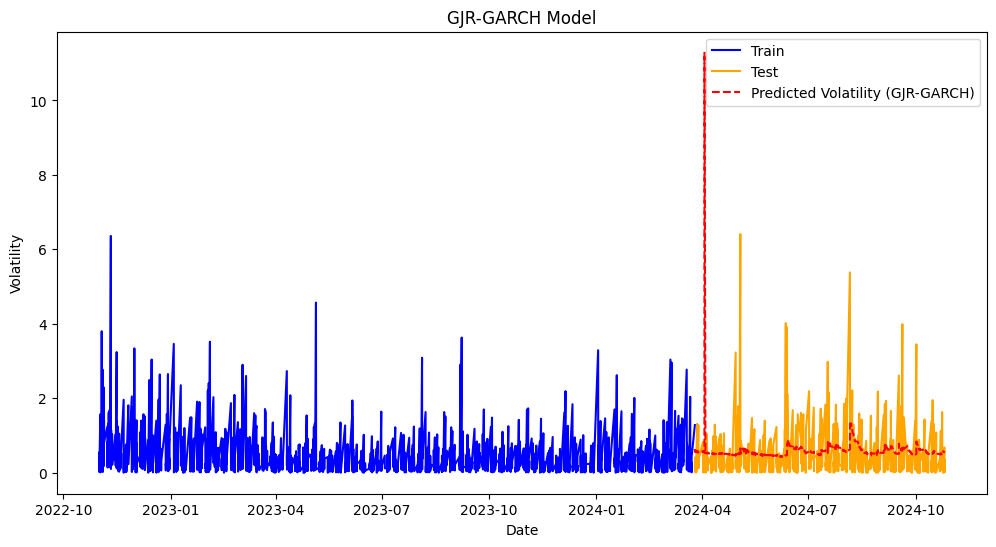

Mean Squared Error (MSE): 0.4406
Root Mean Squared Error (RMSE): 0.6638
Mean Absolute Error (MAE): 0.4271


In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Fitting a GJR-GARCH(1, 1) model to the training data
model = arch_model(train_returns, vol='GARCH', p=1, o=1, q=1, power=2.0, dist='normal')

# iteration limit to 10,000
options = {'maxiter': 10000}
model_fit = model.fit(disp='off', options=options)
print(model_fit.summary())

# Rolling forecast for test set
history = train_returns.tolist()
predicted_volatility = []

for t in range(len(test_returns)):
    # Fit GJR-GARCH on the rolling window (using historical data)
    model = arch_model(history, vol='GARCH', p=1, o=1, q=1, power=2.0, dist='normal')
    try:
        model_fit = model.fit(disp='off', options=options)
    except Exception as e:
        print(f"Rolling forecast iteration {t} generates an error:", e)
        # Fallback to GARCH if fitting fails
        model = arch_model(history, vol='GARCH', p=1, q=1)
        model_fit = model.fit(disp='off', options=options)

    # Forecast the volatility for the next time point
    forecast = model_fit.forecast(horizon=1)
    pred_vol = np.sqrt(forecast.variance.values[-1, 0])

    predicted_volatility.append(pred_vol)
    history.append(test_returns.iloc[t])

predicted_volatility = pd.Series(predicted_volatility, index=test_returns.index)

# Plotting the training, test, and predicted volatility
plt.figure(figsize=(12, 6))
plt.plot(prices.index[:train_size], np.abs(train_returns), label='Train', color="blue")
plt.plot(prices.index[train_size:], np.abs(test_returns), label='Test', color="orange")
plt.plot(prices.index[train_size:], predicted_volatility, label='Predicted Volatility GJR-GARCH', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('GJR-GARCH Model')
plt.legend()
plt.show()

# Calculating performance metrics for volatility predictions
mse = mean_squared_error(np.abs(test_returns), predicted_volatility)
rmse = np.sqrt(mse)
mae = mean_absolute_error(np.abs(test_returns), predicted_volatility)

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
